In [193]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn import set_config
from sklearn.inspection import plot_partial_dependence


In [192]:
import numpy as np
print(np.__version__)


1.19.2


#### CARGAMOS EL DATASET Y EXPLORAMOS LOS DATOS

In [133]:
# Cargar el dataset desde un archivo CSV
df = pd.read_csv('insurance.csv')

# Mostramos las primeras 5filas del dataset
print("Primeras 5filas del dataset:")
print(df.head(5))

# Info nos dara informacion general
print("\nInformación general del dataset:")
print(df.info())

# Describir las estadísticas del dataset
print("\nEstadísticas descriptivas del dataset:")
print(df.describe(include='all'))


Primeras 5filas del dataset:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Estadísticas descriptivas d

In [134]:
# Verificar y manejar valores nulos
print("\nValores nulos en cada columna:")
print(df.isnull().sum())

# Verificar y manejar duplicados
print("\nNúmero de filas duplicadas:")
print(df.duplicated().sum())

# Eliminar filas duplicadas
df = df.drop_duplicates()



Valores nulos en cada columna:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Número de filas duplicadas:
1


In [135]:
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [136]:
df['sex'].unique()

array(['female', 'male'], dtype=object)

In [137]:
df['smoker'].unique()

array(['yes', 'no'], dtype=object)

#### APLICAMOS FEATURE ENGINNERING

In [138]:
# Crear características adicionales
df['bmi_smoker'] = df['bmi'] * df['smoker'].apply(lambda x: 1 if x == 'yes' else 0)


In [139]:
# Dividir el conjunto de datos en características (X) y la columna objetivo (y)
X = df.drop(columns=['charges'])
y = df['charges']

# Dividir en conjunto de entrenamiento y conjunto de prueba en 80% y 20% para el conjunto de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [140]:
# Detectar valores nulos
print("\nValores nulos en cada columna:")
print(df.isnull().sum())

# Mostrar filas con valores nulos
print("\nFilas con valores nulos:")
print(df[df.isnull().any(axis=1)])


Valores nulos en cada columna:
age           0
sex           0
bmi           0
children      0
smoker        0
region        0
charges       0
bmi_smoker    0
dtype: int64

Filas con valores nulos:
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges, bmi_smoker]
Index: []


#### CREAMOS PIPELINE PARA UNA REGRESION LINEAL MULTIPLE

In [164]:
# Seleccionar las columnas numéricas y categóricas
numeric_features = ['age', 'bmi', 'children', 'bmi_smoker']
categorical_features = ['sex', 'smoker', 'region']

# Crear transformadores para el preprocesamiento
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first')) # drop='first' para evitar la multicolinealidad
])

# Combinar transformadores en un preprocesador ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear un pipeline completo con preprocesamiento y modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ('regressor', LinearRegression())
])

# Visualizar el pipeline
set_config(display='diagram')
pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children',
                                                   'bmi_smoker']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('regressor', LinearRegression())])

In [163]:
# Entrenar el modelo con el pipeline
pipeline.fit(X_train, y_train)

# Hacer predicciones con el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Guardar el modelo entrenado en un archivo
joblib.dump(pipeline, 'linear_regression_model.pkl')


Mean Squared Error: 20910602.63076843
R^2 Score: 0.8862045574393044


['linear_regression_model.pkl']

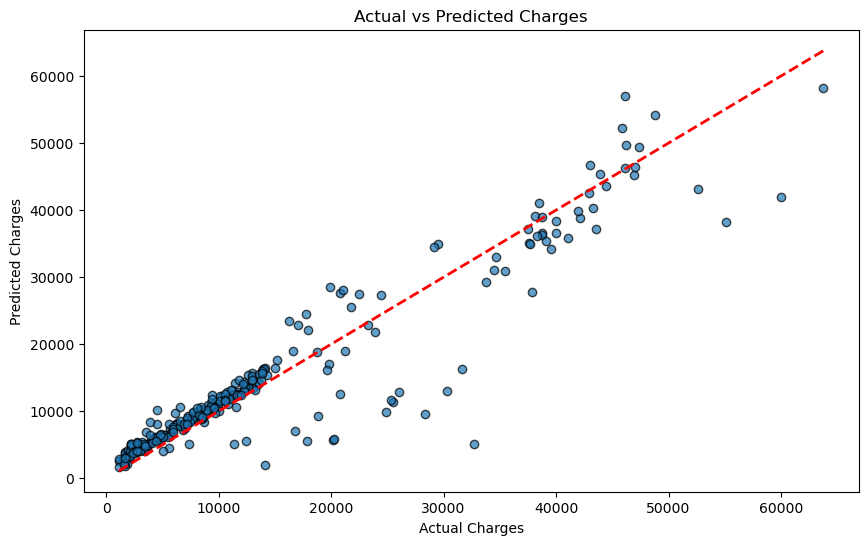

In [143]:
# Comparar los valores reales vs predichos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--', linewidth=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')
plt.show()

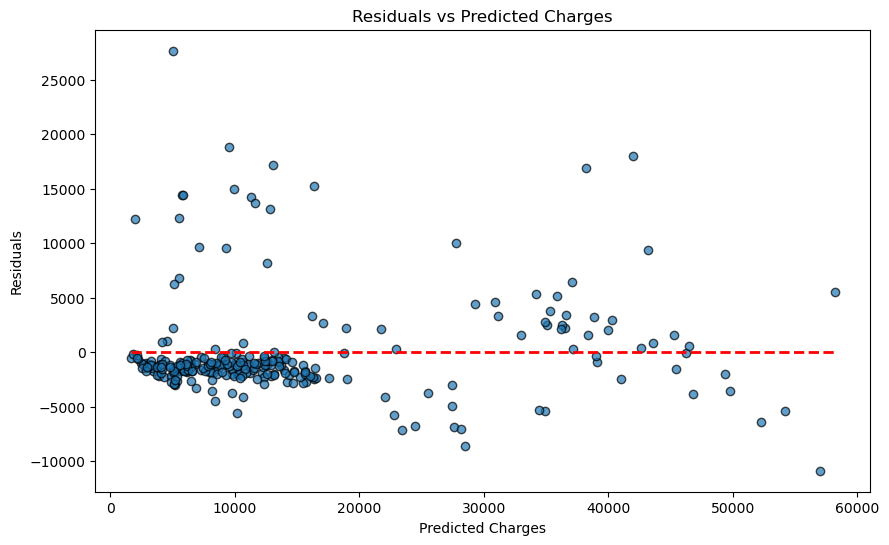

In [144]:
# Calcular los errores residuales
residuals = y_test - y_pred

# Gráfico de los errores residuales
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, edgecolor='k', alpha=0.7)
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Charges')
plt.show()

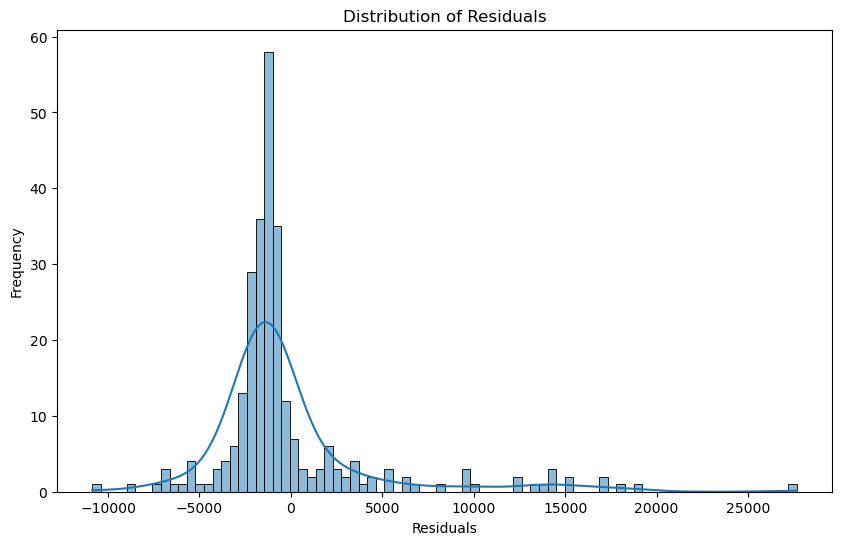

In [145]:
# Histograma de los residuos
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

#### REGRESION POLINOMICA

In [146]:
# Crear un pipeline completo con preprocesamiento y modelo de regresión polinomial
pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', LinearRegression())
])

# Entrenar el modelo de regresión polinomial
pipeline_poly.fit(X_train, y_train)

# Hacer predicciones con el conjunto de prueba
y_pred_poly = pipeline_poly.predict(X_test)

# Evaluar el modelo de regresión polinomial
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f'Polynomial Regression Mean Squared Error: {mse_poly}')
print(f'Polynomial Regression R^2 Score: {r2_poly}')

# Guardar el modelo entrenado
joblib.dump(pipeline_poly, 'polynomial_regression_model.pkl')

Polynomial Regression Mean Squared Error: 21677931.44166074
Polynomial Regression R^2 Score: 0.8820287561404657


['polynomial_regression_model.pkl']

#### RIDGE REGRESSION

In [147]:
# Crear y entrenar modelo Ridge
pipeline_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

# Definir los parámetros para la búsqueda de hiperparámetros
param_grid_ridge = {'ridge__alpha': [0.1, 1.0, 10.0, 100.0]}
grid_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=5)
grid_ridge.fit(X_train, y_train)

# Hacer predicciones con el conjunto de prueba
y_pred_ridge = grid_ridge.predict(X_test)

# Evaluar el modelo Ridge
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f'Ridge Regression Mean Squared Error: {mse_ridge}')
print(f'Ridge Regression R^2 Score: {r2_ridge}')

# Guardar el modelo entrenado
joblib.dump(grid_ridge, 'ridge_regression_model.pkl')

Ridge Regression Mean Squared Error: 20880159.413249154
Ridge Regression R^2 Score: 0.8863702293461235


['ridge_regression_model.pkl']

#### LASSO REGRESSION

In [148]:
# Crear y entrenar modelo Lasso
pipeline_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso())
])

# Definir los parámetros para la búsqueda de hiperparámetros
param_grid_lasso = {'lasso__alpha': [0.1, 1.0, 10.0, 100.0]}
grid_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=5)
grid_lasso.fit(X_train, y_train)

# Hacer predicciones con el conjunto de prueba
y_pred_lasso = grid_lasso.predict(X_test)

# Evaluar el modelo Lasso
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f'Lasso Regression Mean Squared Error: {mse_lasso}')
print(f'Lasso Regression R^2 Score: {r2_lasso}')

# Guardar el modelo entrenado
joblib.dump(grid_lasso, 'lasso_regression_model.pkl')

Lasso Regression Mean Squared Error: 20909639.673083905
Lasso Regression R^2 Score: 0.8862097978524006


['lasso_regression_model.pkl']

#### VISUALIZAMOS LOS RESULTADOS, COMO SE TRATA DE UNA REGRESION DE MULTIPLES VARIABLES LA RECTA PREDICTORA ESTA EN N DIMENSIONES POR LO QUE NO SE PUEDE VISUALIZAR CON EXACTITUT

##### COMO NO SE PUEDE USAR LA RECTA PREDICTORA PARA LA VISUALIZACION USAREMOS LA RECTA DE REFERENCIA.

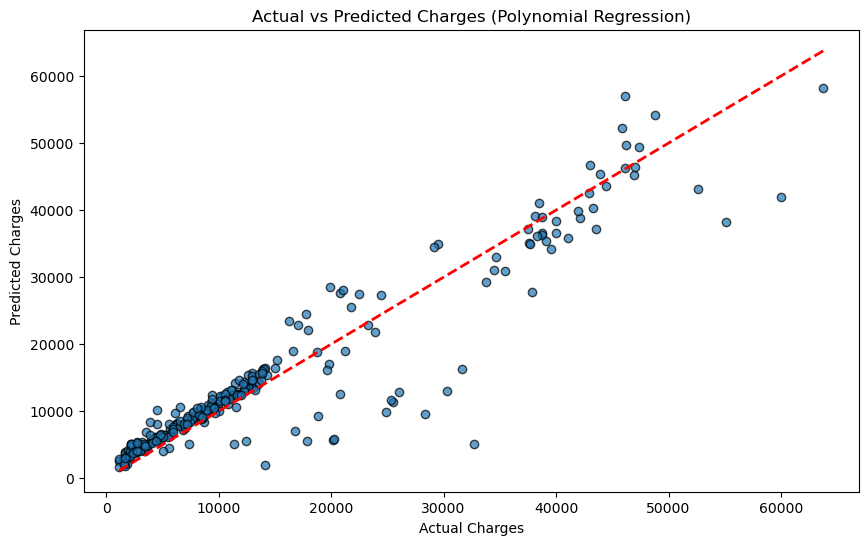

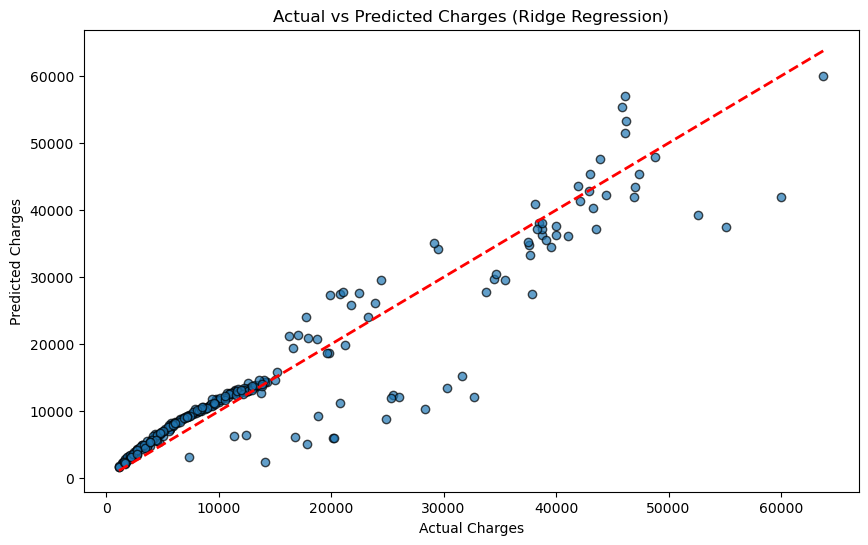

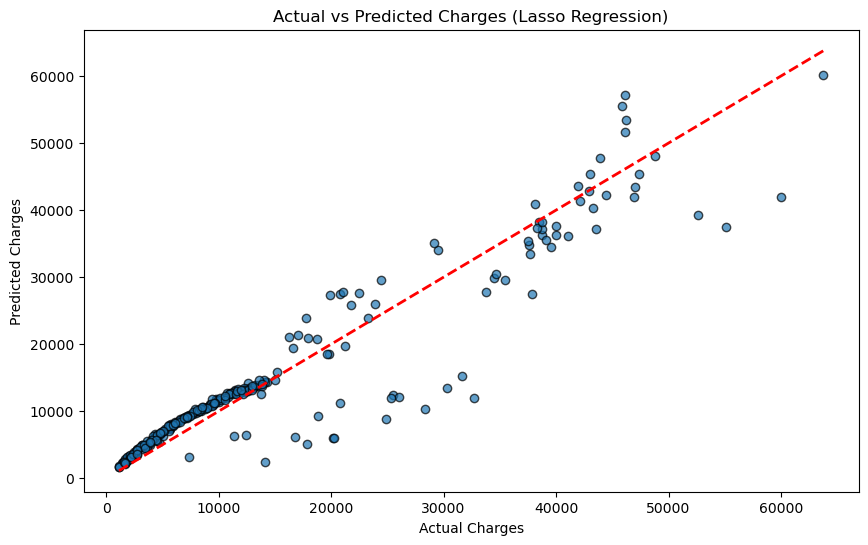

In [149]:
# Comparar los valores reales vs predichos para cada modelo
models = {
    'Polynomial Regression': (y_test, y_pred_poly),
    'Ridge Regression': (y_test, y_pred_ridge),
    'Lasso Regression': (y_test, y_pred_lasso)
}

for model_name, (actual, predicted) in models.items():
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predicted, edgecolor='k', alpha=0.7)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='r', linestyle='--', linewidth=2)
    plt.xlabel('Actual Charges')
    plt.ylabel('Predicted Charges')
    plt.title(f'Actual vs Predicted Charges ({model_name})')
    plt.show()

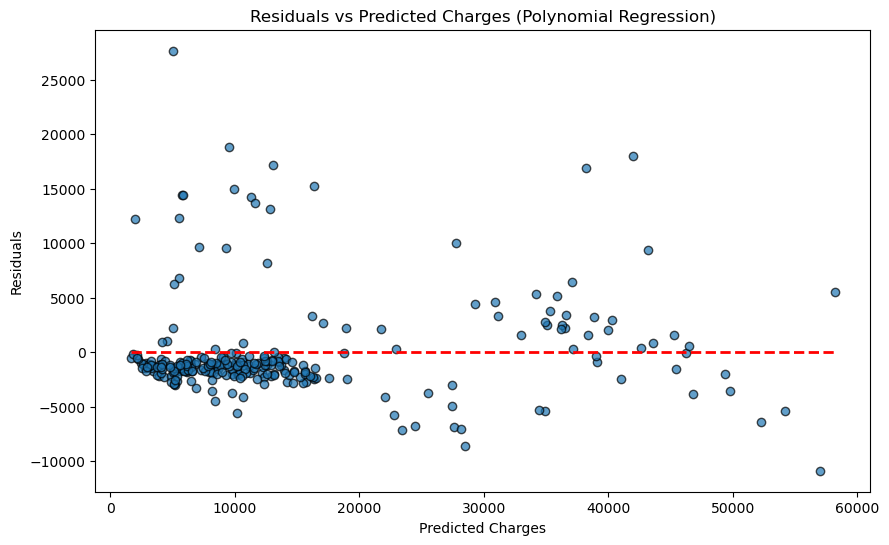

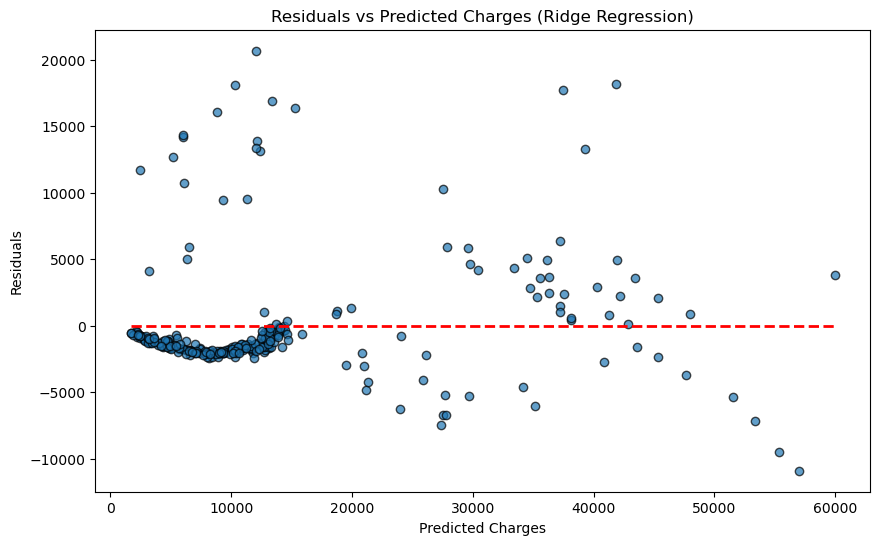

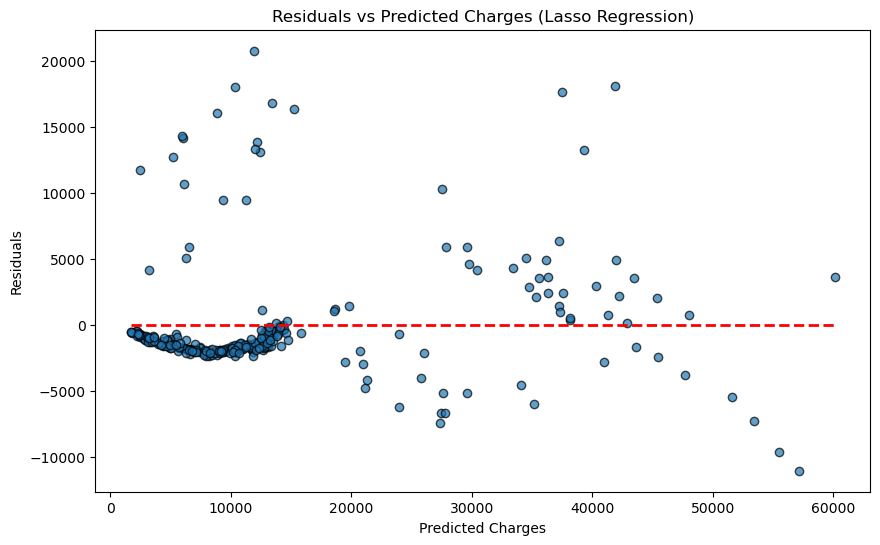

In [150]:
# Gráfico de los errores residuales para cada modelo
for model_name, (actual, predicted) in models.items():
    residuals = actual - predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(predicted, residuals, edgecolor='k', alpha=0.7)
    plt.hlines(y=0, xmin=min(predicted), xmax=max(predicted), color='r', linestyle='--', linewidth=2)
    plt.xlabel('Predicted Charges')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Predicted Charges ({model_name})')
    plt.show()


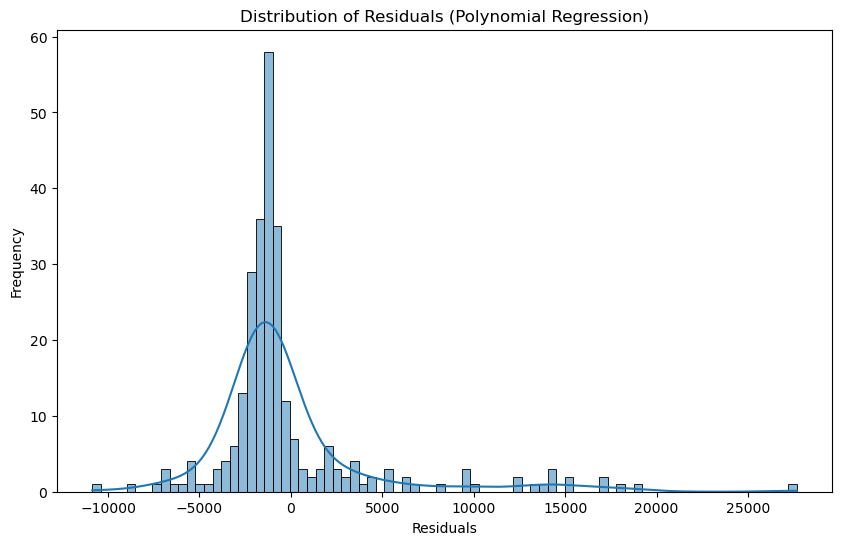

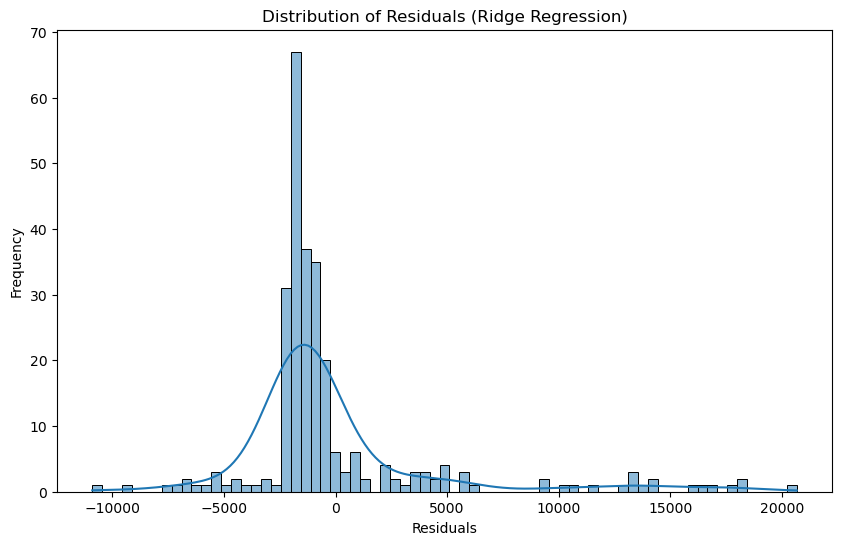

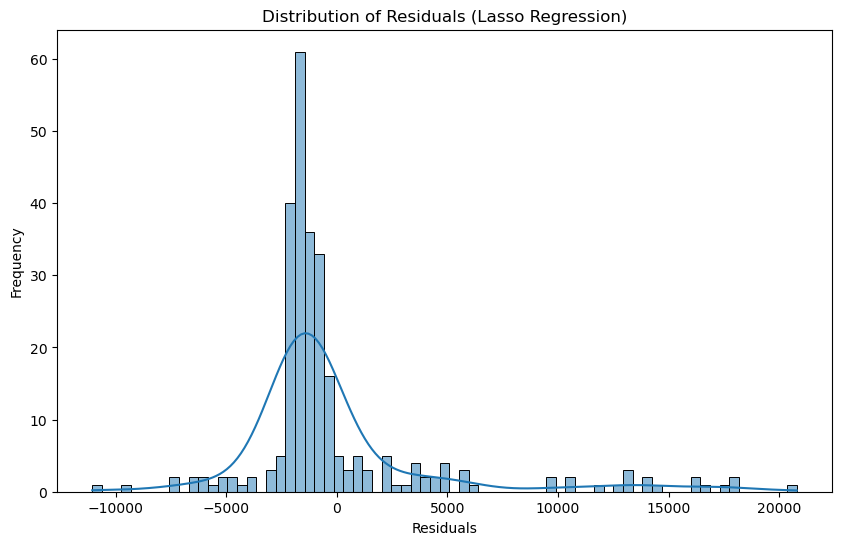

In [151]:
# Histograma de los residuos para cada modelo
for model_name, (actual, predicted) in models.items():
    residuals = actual - predicted
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title(f'Distribution of Residuals ({model_name})')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()
